In [1]:
import os
# os.environ['DEVICE_ID'] = '6'
import csv
import numpy as np
import mindspore as ms
from mindspore import nn
from mindspore import context
from mindspore import dataset
from mindspore.train.callback import LossMonitor
from mindspore.common.api import ms_function
from mindspore.ops import operations as P
context.set_context(mode=context.GRAPH_MODE, device_target="Ascend")

In [2]:
with open('iris.txt') as csv_file:
 data = list(csv.reader(csv_file, delimiter=','))

In [3]:
label_map = {
 'Iris-setosa': 0,
 'Iris-versicolor': 0.5,
 'Iris-virginica': 1
}
X = np.array([[float(x) for x in s[:-1]] for s in data[:150]], np.float32)
Y = np.array([[label_map[s[-1]]] for s in data[:150]], np.float32)

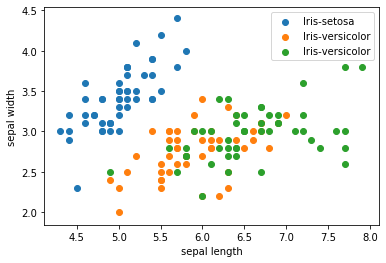

In [4]:
from matplotlib import pyplot as plt
plt.scatter(X[:50, 0], X[:50, 1], label='Iris-setosa')
plt.scatter(X[50:100, 0], X[50:100, 1], label='Iris-versicolor')
plt.scatter(X[101:, 0], X[101:, 1], label='Iris-versicolor')
plt.xlabel('sepal length')
plt.ylabel('sepal width')
plt.legend()


In [5]:
train_idx = np.random.choice(100, 80, replace=False)
test_idx = np.array(list(set(range(100)) - set(train_idx)))
X_train, Y_train = X[train_idx], Y[train_idx]
X_test, Y_test = X[test_idx], Y[test_idx]

In [6]:
XY_train = list(zip(X_train, Y_train))
XY_train_qie = XY_train[:80]
ds_train = dataset.GeneratorDataset(XY_train_qie, ['x', 'y'])
ds_train = ds_train.shuffle(buffer_size=80).batch(32, drop_remainder=True)

Text(0, 0.5, 'p')

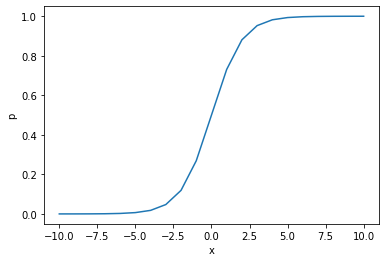

In [7]:
coor_x = np.arange(-10, 11, dtype=np.float32)
coor_y = nn.Sigmoid()(ms.Tensor(coor_x)).asnumpy()
plt.plot(coor_x, coor_y)
plt.xlabel('x')
plt.ylabel('p')


In [8]:
# 自定义 Loss
class Loss(nn.Cell):
     def __init__(self):
         super(Loss, self).__init__()
         self.sigmoid_cross_entropy_with_logits = P.SigmoidCrossEntropyWithLogits()
         self.reduce_mean = P.ReduceMean(keep_dims=False)
     def construct(self, x, y):
         loss = self.sigmoid_cross_entropy_with_logits(x, y)
         return self.reduce_mean(loss, -1)
net = nn.Dense(4, 1)
loss = Loss()
opt = nn.optim.SGD(net.trainable_params(), learning_rate=0.003)


In [9]:
model = ms.train.Model(net, loss, opt)
model.train(5, ds_train, callbacks=[LossMonitor(per_print_times=ds_train.get_dataset_size())], 
dataset_sink_mode=False)

epoch: 1 step: 2, loss is 0.639824390411377
epoch: 2 step: 2, loss is 0.6168457269668579
epoch: 3 step: 2, loss is 0.5673115253448486
epoch: 4 step: 2, loss is 0.5135533809661865
epoch: 5 step: 2, loss is 0.5261256098747253


In [10]:
x = model.predict(ms.Tensor(X_test)).asnumpy()
pred = np.round(1 / (1 + np.exp(-x)))
correct = np.equal(pred, Y_test)
acc = np.mean(correct)
print('Test accuracy is', acc)


Test accuracy is 0.55
